In [1]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np 
import pandas as pd 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [27]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Flatten, LeakyReLU, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout


In [3]:
os.chdir("/kaggle/input/dogs-vs-cats-redux-kernels-edition")

In [4]:
!unzip -q train.zip -d /kaggle/working/

replace /kaggle/working/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
!unzip -q test.zip -d /kaggle/working/

replace /kaggle/working/test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [16]:
train_image_list = os.listdir("/kaggle/working/train")
test_image_list = os.listdir("/kaggle/working/test")

In [17]:
img_path_list = []
label_list = []
for img in train_image_list:
    img_path = os.path.join('/kaggle/working/train',img)
    img_path_list.append(img_path)
    label = img.split('.')[0]
    label_list.append(label)
    
train_df = pd.DataFrame()
train_df['img_path'] = img_path_list
train_df['label'] = label_list
train_df['label'] = train_df['label'].map({'cat':0, 'dog':1})

In [18]:
img_path_list = []
for img in test_image_list:
    img_path = os.path.join('/kaggle/working/test',img)
    img_path_list.append(img_path)
test_df = pd.DataFrame()
test_df['img_path'] = img_path_list

In [19]:
train_df.head()

,img_path,label
0,/kaggle/working/train/dog.3443.jpg,1
1,/kaggle/working/train/cat.12488.jpg,0
2,/kaggle/working/train/dog.6092.jpg,1
3,/kaggle/working/train/dog.5691.jpg,1
4,/kaggle/working/train/cat.5079.jpg,0


In [20]:
test_df.head()

,img_path
0,/kaggle/working/test/1039.jpg
1,/kaggle/working/test/11535.jpg
2,/kaggle/working/test/7094.jpg
3,/kaggle/working/test/4852.jpg
4,/kaggle/working/test/803.jpg


In [21]:
## Split the data
train, validation = train_test_split(train_df, test_size=0.2, random_state=42)

In [22]:
total_train = train.shape[0]
total_val = validation.shape[0]

In [23]:
## Data Augmentation
import random
image_height = 128
image_width = 128
def img_transformation(image_path, label):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.image.resize(image, (image_height, image_width))
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     image /=  255.0
    final_image = keras.applications.xception.preprocess_input(image)
    return final_image, label

In [24]:
batch_size = 32

## Construct TensorFlow datasets using tf.data.Dataset.from_tensor_slices
train_data = tf.data.Dataset.from_tensor_slices((train['img_path'].values, train['label'].values))
val_data = tf.data.Dataset.from_tensor_slices((validation['img_path'].values, validation['label'].values))

## batch: groups consecutive elements of the dataset into batches of size 
## prefetch: allow the data pipeline to asynchronously fetch batches of data while the model is training on the current batch
## it helps reduce training time by overlapping the data preprocessing and model execution phases.
train_dataset = train_data.map(lambda x, y: img_transformation(x, y)).batch(batch_size).prefetch(1)

## shuffle: randomly sample batches of 1000 elements from the dataset and shuffle them
## it introduces randomness into the training process
train_dataset = train_dataset.shuffle(1000).repeat()

val_dataset = val_data.map(lambda x, y: img_transformation(x, y)).batch(batch_size).prefetch(1)

## Xception Model

In [28]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
base_model.trainable = False

inputs = keras.Input(shape=(image_height, image_width, 3))
x = base_model(inputs, training=False)
x = LeakyReLU()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
cnn_model = Model(inputs, outputs)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [29]:
## learning rate determines the step size taken during optimization to update the model's parameters
initial_learning_rate = 0.01

## ExponentialDecay: gradually reduces the learning rate over time
## - decay_steps=1000: every 1000 steps the learning rate should decay
## - decay_rate=0.5: the learning rate will be halved every 1000 steps
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

In [31]:
epochs = 50
history = cnn_model.fit(
    train_dataset,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_dataset,
    steps_per_epoch=int(total_train / batch_size),
    callbacks=[early_stopping]
)

Epoch 1/50
625/625 [==============================] - 52s 35ms/step - loss: 0.2504 - accuracy: 0.9398 - val_loss: 0.1039 - val_accuracy: 0.9552
Epoch 2/50
625/625 [==============================] - 21s 33ms/step - loss: 0.1294 - accuracy: 0.9490 - val_loss: 0.1079 - val_accuracy: 0.9544
Epoch 3/50
625/625 [==============================] - 21s 34ms/step - loss: 0.1091 - accuracy: 0.9560 - val_loss: 0.1043 - val_accuracy: 0.9580
Epoch 4/50
625/625 [==============================] - 21s 34ms/step - loss: 0.0968 - accuracy: 0.9613 - val_loss: 0.0885 - val_accuracy: 0.9614
Epoch 5/50
625/625 [==============================] - 22s 35ms/step - loss: 0.0826 - accuracy: 0.9675 - val_loss: 0.0874 - val_accuracy: 0.9638
Epoch 6/50
625/625 [==============================] - 21s 34ms/step - loss: 0.0731 - accuracy: 0.9715 - val_loss: 0.0888 - val_accuracy: 0.9632
Epoch 7/50
625/625 [==============================] - 22s 34ms/step - loss: 0.0662 - accuracy: 0.9744 - val_loss: 0.0894 - val_accuracy:

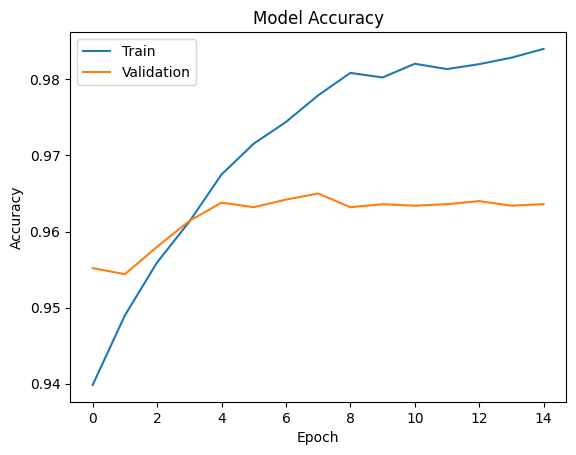

In [32]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

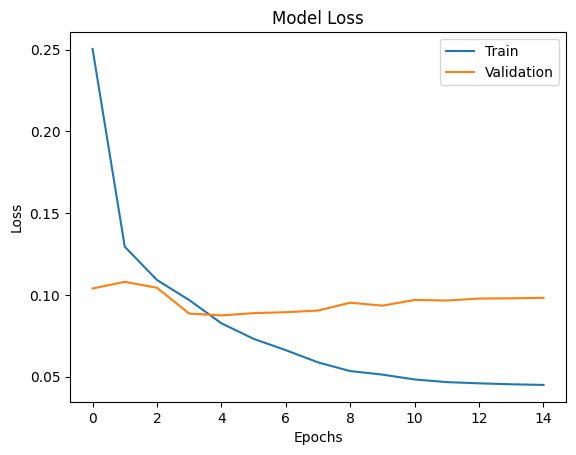

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

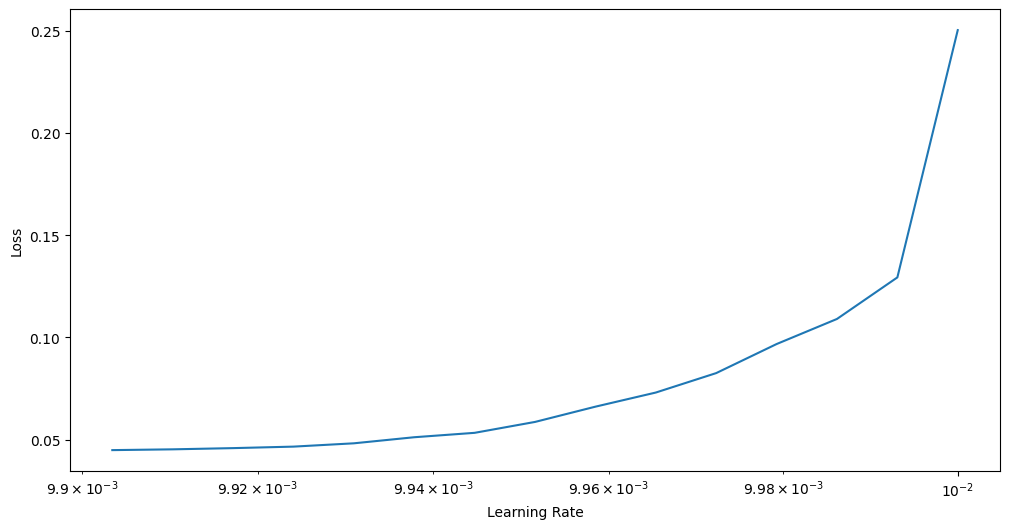

In [34]:
import matplotlib.pyplot as plt

lrs = lr_schedule(tf.range(len(history.history['loss'])))
plt.figure(figsize=(12, 6))
plt.semilogx(lrs, history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()


In [35]:
min = 1
index = -1
for i in range(len(history.history['loss'])):
    if history.history['loss'][i] < min:
        min = history.history['loss'][i]
        index +=1

In [36]:
best_learning_rate = lrs[index]
print(float(best_learning_rate))

0.00990342814475298


In [37]:
def img_transformation_test(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.image.resize(image, (image_height, image_width))
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     image /=  255.0
    final_image = keras.applications.xception.preprocess_input(image)
    return final_image

In [38]:
batch_size = 32

test_data = tf.data.Dataset.from_tensor_slices(test_df['img_path'].values)
test_dataset = test_data.map(lambda x: img_transformation_test(x)).batch(batch_size)

In [39]:
predictions = cnn_model.predict(test_dataset)
predictions = predictions.flatten()

391/391 [==============================] - 12s 29ms/step


In [40]:
MSBA_Session1_YunchenHsieh = pd.DataFrame()
MSBA_Session1_YunchenHsieh['label'] = predictions
MSBA_Session1_YunchenHsieh['id'] = test_df['img_path'].apply(lambda x: x.split('/')[4].split('.')[0])
MSBA_Session1_YunchenHsieh = MSBA_Session1_YunchenHsieh[['id', 'label']]

In [41]:
MSBA_Session1_YunchenHsieh.sort_values(by='id', inplace=True, ignore_index = True)

In [42]:
MSBA_Session1_YunchenHsieh.head(10)

,id,label
0,1,1.000000e+00
1,10,3.803603e-06
2,100,1.388055e-04
3,1000,9.999995e-01
4,10000,1.000000e+00
5,10001,8.815180e-08
6,10002,9.680801e-09
7,10003,9.999859e-01
8,10004,5.663947e-01
9,10005,4.486674e-08


In [43]:
MSBA_Session1_YunchenHsieh.to_csv('/kaggle/working/MSBA_Session1_YunchenHsieh.csv', index=False)